<b><font size=18, color='slateblue'>Datashader</font></b>

Adrianna Modelska and Anya Wolterman<br>
10/25/23<br>

#### <span style="color:green">Learning Goals</span>
Mirroring the outline of this tutorial, by the end of this notebook you will
1. Understand how the datashader package works (i.e. why it can visualize big data so fast)
2. Become acquainted with datashader's wide variety of applications, focusing on its trimesh functionality
3. Use trimesh in datashader to model a coastal bay

#### Resources
Datashader: <br>
[Datashader homepage](https://datashader.org/index.html) <br>
[User Guide](https://datashader.org/user_guide/index.html) for all the information you could possibly need on Datashader<br>
[Other examples using datashader](https://examples.holoviz.org)<br>
[HoloViz/Datashader GitHub](https://github.com/holoviz/datashader)<br>
[8-minute video on datashader from Dr. Sophia Yang](https://www.youtube.com/watch?v=U6dyIRolIhI)<br>
[API (Application Programming Interface)](https://datashader.org/api.html)<br>

Information on other HoloViz libraries: <br>
[HoloViz homepage](https://holoviz.org)<br>
[HoloViz SciPy Tutorial](https://www.youtube.com/watch?v=7deGS4IPAQ0) for a full tutorial on data visualizations, including via datashader <br>


First step, as always, is to import useful packages, including datashader

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import datashader as ds
import datashader.transfer_functions as tf
import datashader.utils as du

---

## 1. What is Datashader?
[Datashader](https://datashader.org) is an open-source Python library for analyzing and visualizing large datasets. It has been developed and maintained by [Anaconda](https://www.anaconda.com) as part of the [HoloViz](https://holoviz.org) ecosystem. HoloViz features several high-level tools that specialize in making data visualization more straightforward, accurate, and powerful, including: Panel, hvPlot, HoloViews, GeoViews, Lumen, Param, Colorcet, and <u>Datashader</u>.<br>

When it comes to visualizing big data, there are two primary concerns: speed (and preventing Jupyter kernel crashes) and image quality. Datashader is able to create meaningful representations of large datasets so quickly because it divides the image rendering into explicit steps, which is why it is referred to as a data rasterization/graphics __pipeline__. There are five steps in datashader's conversion of big data into a 2D plot, listed below and shown in the schematic:

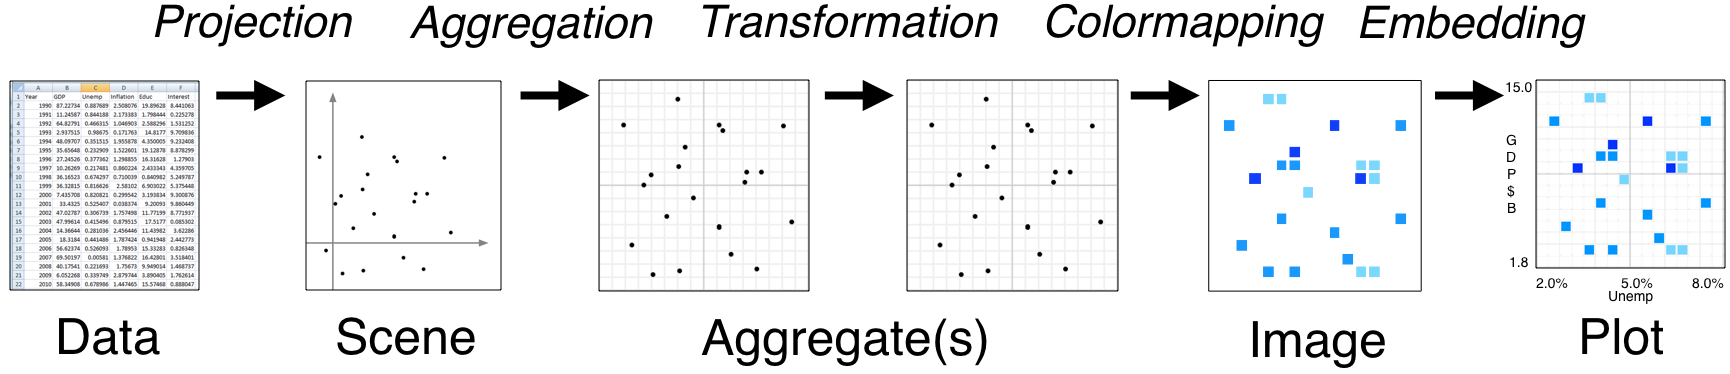
1. <i>Projection</i>
    * Create a canvas with desired number of pixels and plotting grid shape, then project each data point into zero or more bins on that grid
2. <i>Aggregation</i>
    * Combine the results per pixel/compute the reduction per bin, compressing the dataset into a much smaller aggregate array
3. <i>Transformation</i>
    * Select only a range of data, mask the data based on other datasets or values, or other further processing
4. <i>Colormapping</i>
    * Turn aggregate(s) into a rendered image
5. <i>Embedding</i>
    * Embed that image into a plot, so labels, colorbars, etc. can be added

This highly-optimized sequence of steps also allows computations to be done on intermediate representations of the data, and visualizations can be produced efficiently without trial-and-error parameter tuning. Datashader can be used on its own, with another visualization library like [HoloViews](https://holoviews.org) or [Bokeh](https://docs.bokeh.org/en/latest/) (to make plots interactive!), or as a pre-processing stage in a plotting library, thereby allowing that library to work with much larger datasets than it otherwise would be able to.<br>

#### TLDR: Datashader makes nice-looking plots of large datasets fast!

## 2. What can Datashader do?

To illustrate Datashader's capabilities, we'll start with a very simple example. Let's look at a synthetic dataset of five overlapping 2D Gaussian (normal) distributions with different spatial scales.

In [ ]:
num = 200000 # number of points per distribution
np.random.seed(1) # seed random number generator with initial value

dists = {cat: pd.DataFrame(dict([('x',np.random.normal(x,s,num)),
                                 ('y',np.random.normal(y,s,num)),
                                 ('cat',cat)]))
         for x, y, s, cat in
         [(4, 4, 0.1, 'd1'),
          (4, -4, 0.4, 'd2'),
          (-4, 4, 1.0, 'd3'),
          (-4, -4, 1.5, 'd4'),
          (0, 0, 0.6, 'd5')]}

df = pd.concat(dists,ignore_index=True)
df['cat'] = df['cat'].astype('category')

Let's check how many rows are in our dataframe by looking at the last five rows:

In [ ]:
df.tail()

Now, we can make a Datashader plot that puts all those (x,y) coordinates from the five normal distributions into one image. <br>

For extra fun, we'll use HoloViews to make it interactive. After running the code below, try moving the plot around and zooming in!

In [ ]:
# Quick Datashader plot to look at all million coordinates
%time tf.shade(ds.Canvas().points(df,'x','y'))

# Turn image into an interactive plot with HoloViews
import holoviews as hv
from holoviews.operation.datashader import datashade
hv.extension('bokeh')
datashade(hv.Points(df))

Datashader can work with columnar data (e.g. from a Pandas dataframe like the one we just made), gridded multidimensional data from Xarray, and many other forms. It can accept a wide variety of data items, all of which it can turn into a regularly-sampled array or corresponding pixel-based image:
* Scatterplot points - x,y pairs
* Line segments - e.g. time series, trajectories
* Areas - for filled-area plots
* Polygons - for chloropleth maps
* Gridded data - all regridded to a regular rectangular grid
    * Rasters
    * Quadmeshes
    * Trimeshes

All of these concepts are explained in detail in the Datashader [User Guide](https://datashader.org/user_guide/index.html), but we will focus our attention on using datashader on <b>trimeshes</b> for the rest of this notebook.

---

## 3. Trimesh
Triangular meshes are often used to simulate data on an irregular grid since any shape can be approximated by sets of triangles. In Datashader, triangular mesh rasterization involves generating values along specified, regularly-spaced intervals in the 2D plane (which corresponds to the <i>surface</i> represented by the 3D triangular mesh). The following examples are modified from the Datashader [User Guide](https://datashader.org/user_guide/Trimesh.html).

Let's again start with a small-scale example: a set of 20 vertices in located randomly in (x,y,z)-space.

In [ ]:
n = 20
np.random.seed(1)

x = np.random.uniform(size=n)
y = np.random.uniform(size=n)
z = np.random.uniform(0,1.0,x.shape)
pts = np.stack((x,y,z)).T
verts = pd.DataFrame(np.stack((x,y,z)).T, columns=['x','y','z'])

# Plotting the vertices
cvs = ds.Canvas(plot_height=400,plot_width=400)
tf.Images(verts.head(15), tf.spread(tf.shade(cvs.points(verts,'x','y',agg=ds.mean('z')),name='Points')))

Note: the `agg` argument in the last line specifies the reduction function that determines how the values around a given pixel contribute to its value, so it can be `mean()`, `count()`, `min()`, `max()`, etc.<br>

Now, we'll construct the trimesh for these vertices. In order to connect these points together in <i>non-overlapping</i> triangles, we can follow the [Delaunay](https://gwlucastrig.github.io/TinfourDocs/DelaunayIntro/index.html) method of triangulation (which we will need to import from SciPy).

In [ ]:
from scipy.spatial import Delaunay

def triangulate(vertices, x='x', y='y'):
    # Generate a triangular mesh for the given x,y,z vertices using Delaunay triangulation
    # For large numbers of vertices, this typically results in about double the number of triangles as vertices
    triang = Delaunay(vertices[[x,y]].values)
    print('Given', len(vertices), "vertices, created", len(triang.simplices), 'triangles.')
    return pd.DataFrame(triang.simplices, columns=['v0', 'v1', 'v2'])

%time tris = triangulate(verts)

The set of triangles we just created can then be visualized with Datashader's `trimesh()` method:

In [ ]:
tf.Images(tris.head(15), tf.shade(cvs.trimesh(verts, tris, interpolate='nearest'), name='20 Vertices'),
          tf.shade(cvs.trimesh(verts, tris, interpolate='linear'), name='20 Vertices Interpolated'))

Obviously, datashader is designed to work with much larger datasets than just 20 points, so let's move on to a more complex example.<br>

First, we'll define a sinusoidal function whose frequency varies with radius:

In [ ]:
rad = (0.01,1.0) # (inner radius, outer radius)

def f(x,y):
    rsq = x**2+y**2 # equation for a circle
    return np.where(np.logical_or(rsq<rad[0],rsq>rad[1]), np.nan, np.sin(4/rsq))

In [ ]:
n = 400
ls  = np.linspace(-1.0, 1.0, n)
x,y = np.meshgrid(ls, ls)
img = f(x,y)

raster = tf.shade(tf.Image(img, name="Raster"))
raster

Sure, this looks cool, but you'll notice some pronounced aliasing towards the center of the circle where the function frequency starts to exceed the raster sampling density. This comes from us sampling at regularly spaced locations, which won't be able to capture the detail near the center, so let's try sampling the function at random locations but with varying density as a function of distance from the center:

In [ ]:
def polar_dropoff(n, r_start=0.0, r_end=1.0):
    # Function to generate new distributions of x,y points that are more concentrated towards the center, not regularly-spaced like meshgrid
    ls = np.linspace(0, 1.0, n)
    ex = np.exp(2-5*ls)/np.exp(2)
    radius = r_start+(r_end-r_start)*ex
    theta  = np.random.uniform(0.0,1.0, n)*np.pi*2.0
    x = radius * np.cos( theta )
    y = radius * np.sin( theta )
    return x,y

x,y = polar_dropoff(n*n, np.sqrt(rad[0]), np.sqrt(rad[1])) # same inner and outer radius
z = f(x,y) # new x,y distributions into function

verts = pd.DataFrame(np.stack((x,y,z)).T, columns=['x','y','z'])
cvs = ds.Canvas(plot_height=400,plot_width=400)
tf.Images(tf.shade(cvs.points(verts,'x','y'), name='Points'))


This plot shows our new radius-dependent sampling density that should be able to better capture the fine detail of our function near the center. Now we'll triangulate these vertices and pre-compute our updated mesh (which can help save time for larger grids), then plot!

In [ ]:
%time tris = triangulate(verts)
mesh = du.mesh(verts,tris)

In [ ]:
tf.Images(tf.shade(cvs.trimesh(verts, tris, mesh=du.mesh(verts,tris))),*([tf.shade(ds.Canvas(x_range=r, y_range=r).trimesh(verts, tris, mesh=mesh))
            for r in [(0.1,0.8), (0.1,0.4)]]))

This is a much better approximation of our function (still not perfect because this is an approximation after all)! You can zoom in and see the fine detail of the function in the heavily sampled regions, so our spatially variable sampling density helped eliminate the interference patterns seen in the regular-grid version.

---

## 4. AOS-relevant example: Bay Trimesh
The full description of this example can also be found on [here](https://examples.holoviz.org/bay_trimesh/bay_trimesh.html). <br>

As you might expect, many natural processes and landscapes do not fit nicely on a fixed sampling grid, so irregular triangular meshes with varying sampling density are very helpful. With our newfound knowledge of datashader and trimesh, we'll move on to a real-world example: rendering a dataset of elevation/depth from the Chesapeake and Delaware Bays off the East Coast. <br>

We'll read in the (fairly large) data file, and let's take a look and the first and last eight rows of our dataframe.

In [ ]:
file='Chesapeake_and_Delaware_Bays.3dm'
# Create a dataframe
df = pd.read_csv(file,delim_whitespace=True, header=None, skiprows=1,
                 names=('row_type', 'cmp1', 'cmp2', 'cmp3', 'val'), index_col=1)
df.head(8)

In [ ]:
df.tail(8)

We can learn more about out dataframe by doing `.info()`

In [ ]:
df.info()

Thankfully we didn't print out the whole dataframe because... shockingly... there are 1.6 million rows of data!! But then again are we surprised? We shouldn't be because we are using real-life data! Datashader's trimesh will help with plotting such large data.

Next, we'll extract the necessary vertex and triangle arrays we will use with Datashader.
Note in the row_type we have two different entries:
- E3T : triangles specified as indexes into the provided vertices, starting at 1 and increasing
- ND : vertices defined as longitude, latitude and elevation

In [ ]:
e3t = df[df['row_type'] == 'E3T'][['cmp1', 'cmp2', 'cmp3']].values.astype(int) - 1
nd  = df[df['row_type'] == 'ND' ][['cmp1', 'cmp2', 'cmp3']].values.astype(float)
nd[:, 2] *= -1 # Making depth increase

# Creating a dataframe for the vertices and triangles
vert = pd.DataFrame(nd,  columns=['x', 'y', 'z'])
tri  = pd.DataFrame(e3t, columns=['v0', 'v1', 'v2'])
vert

In [ ]:
tri

How many entries are there for both the vertices and triangle?

In [ ]:
print('vertices:', len(vert), 'triangles:', len(tri))

### Plotting Time!
Time to plot our average depth at each location in the bays. We use [ds.Canvas](https://datashader.org/api.html#datashader.Canvas) and it plots an abstract canvas that represents the space in which we will bin our data points. 

In [ ]:
bays = ds.Canvas(plot_height=900, plot_width=900)
mesh = du.mesh(vert,tri)
bay_depth = bays.trimesh(vert, tri, mesh=mesh)
tf.shade(bay_depth) 

Understanding our plot: 
- We are using an irregular triangular grid
- Darker colors = deeper
- The deeper the area the higher the z-value in our vertices dataframe (recall we inverted the z-values a few cells above)

#### More plots!
1) Any: any region/area that is covered by the mesh, therefore we see the whole map in one solid color
2) Count: it counts the # of triangles that are used in the calculation of each pixel (more triangles in the inland area vs. fewer triangles in the offshore area)
3) Standard Deviation (std): how much of your data varies in each pixel and where

In [ ]:
bays = ds.Canvas(plot_height=400, plot_width=400)

tf.Images(tf.shade(bays.trimesh(vert, tri, mesh=mesh, agg=ds.any()),     name="any"),
          tf.shade(bays.trimesh(vert, tri, mesh=mesh, agg=ds.count()),   name="count", how='linear'),
          tf.shade(bays.trimesh(vert, tri, mesh=mesh, agg=ds.std('z')),  name="std")).cols(2)

And lastly, let's make it interactive!

In [ ]:
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import datashade

hv.extension("bokeh")
opts.defaults(
    opts.Image(width=450, height=450),
    opts.RGB(width=450, height=450))
 
trimesh = datashade(hv.TriMesh((tri,hv.Points(vert, vdims='z')), label="TriMesh"), aggregator=ds.mean('z'))
trimesh